In [1]:
from librosa.feature import melspectrogram
from librosa.onset import onset_detect, onset_strength
from scipy import signal
from scipy.io.wavfile import read as wavfile_read
from utils import pairwise, get_time_interval, spectral_analysis, plot_spectrogram, bandpass_filter

import os
import librosa.display
import soundfile as sf
import audioread
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import mido
import pandas as pd
import csv

In [3]:
# References:
# piano note frequency list: http://www.sengpielaudio.com/calculator-notenames.htm
# Data source: http://resources.mpi-inf.mpg.de/SMD/SMD_MIDI-Audio-Piano-Music.html

# Goal detect notes between 252Hz and 1046.50Hz (middle C and two octaves higher C)
folder = '../Data'
sample_file = 'song9.wav'
upper_freq = 1050 
# Get example audio file
filename = os.path.join(folder, sample_file)

# use wavfile instead, much simpler
def load_wav(fname, to_mono=True, to_float=False):
    sample_rate, data = wavfile_read(filename)
    print('sample rate: ', sample_rate)
    
    if to_mono:
        data = data.mean(axis=1)
    if to_float:
        data = data.astype(float)
    # normalize to between 0 and 1
    data = data / (2**16)
    return sample_rate, data

In [4]:
sr, data = load_wav(filename, to_float=True)

sample rate:  44100


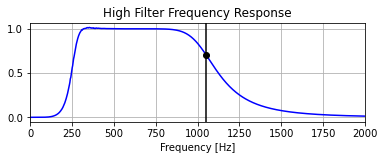

In [5]:
low_freq_cutoff = 262
high_freq_cutoff = 1050
high_notes = bandpass_filter(data, sr, low_freq_cutoff, high_freq_cutoff)

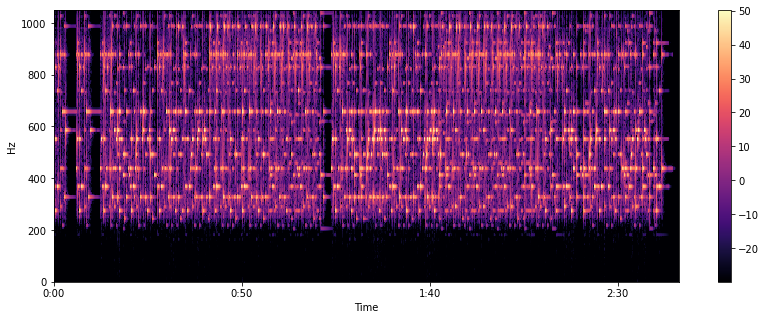

In [6]:
win_length = 8192

spec = spectral_analysis(high_notes, sr, win_length=win_length)
plot_spectrogram(spec, sr, win_length, ylim=upper_freq)

In [7]:
# detect the onsets of notes above middle C (i.e. notes played by right hand)
onsets = onset_detect(high_notes, sr=sr, units='samples', backtrack=True)
print("number of onsets detected: ", len(onsets))

number of onsets detected:  522


In [8]:
# extract notes with onset indices
def extract_notes(notes_data, sr, onsets):
    notes, timestamps = [], []
    for idx, (start, end) in enumerate(pairwise(onsets)):
#         print(f"idx: {idx}, note length: {end - start}")
        notes.append(notes_data[start: end])
        timestamps.append(start / sr)
    
    return notes, timestamps

In [9]:
onsets_extracted, onsets_timestamps = extract_notes(high_notes, sr, onsets)

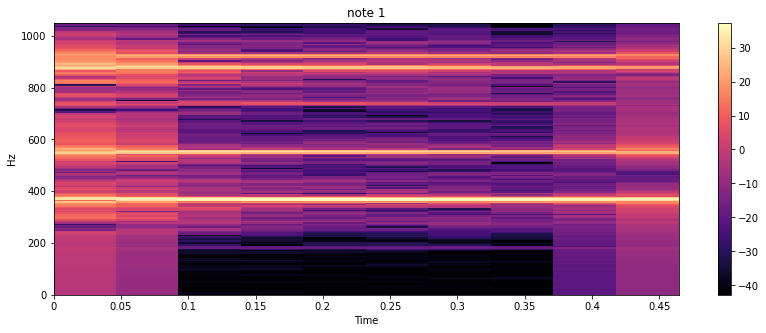

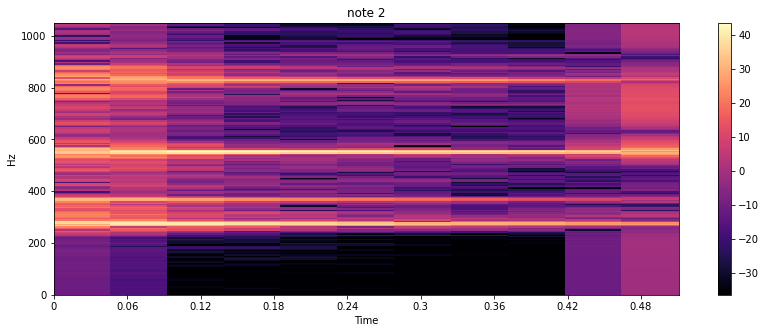

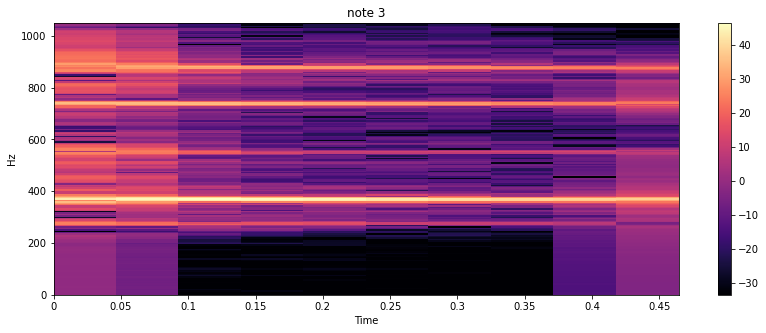

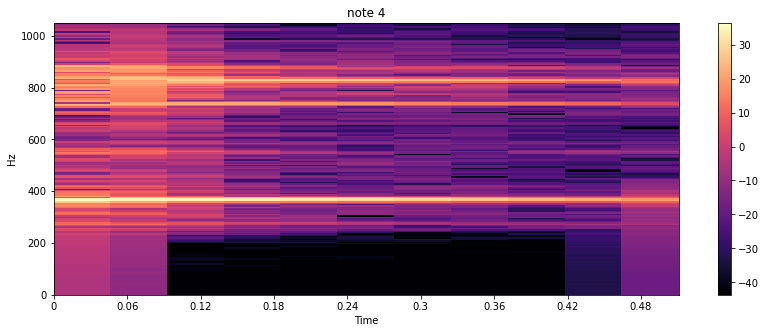

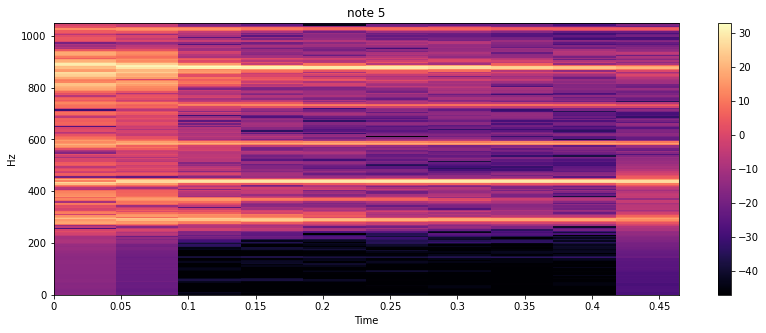

In [10]:
# plot melspectrogram of some notes (e.g. first five notes)
for idx in range(5): # plot first 20 notes
    note_data = onsets_extracted[idx]
    note_dB = spectral_analysis(note_data, sr, win_length=win_length)
    plot_spectrogram(note_dB, sr, win_length, ylim=upper_freq)
    plt.title(f"note {idx+1}")

In [20]:
# save notes as npz
notes_folder = os.path.join(folder, 'river_notes')
os.makedirs(notes_folder)
    
# save the playing of notes into a directory
for idx, note in enumerate(onsets_extracted):
    note_data = onsets_extracted[idx]
    
    with open(os.path.join(notes_folder, f'note_{idx}.npy'), 'wb') as f:
        np.save(f, note_data)

In [21]:
'''
  Converts Numbers to actual Not name and octave
'''
NOTES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
OCTAVES = list(range(11))
NOTES_IN_OCTAVE = len(NOTES)


def number_to_note(number):
    octave = int (number / 12) - 1
    assert octave in OCTAVES
    assert 0 <= number <= 127
    note = NOTES[number % NOTES_IN_OCTAVE]

    note = note + str(octave)
    return note

In [22]:
ticks_per_beat = 256 #256 ticks per beat, tick is the smallest unit
tempo = 65 #bpm

# the number of second for a quarter note (useful for grouping multi-notes).
# if multiple notes are played within time_bin, we consider that they are
# played at the same time. (for us, I think the length of a quarter note divided
# by four is good?)
time_bin = mido.tick2second(128, ticks_per_beat, mido.bpm2tempo(tempo)) / 4

In [23]:
'''
  Same Function as previous cell but it handles chords. Each list inside of 'right_hand_notes' contains the note(s) 
  that are played at that time instance
'''

sample_file = 'song9.mid'
mid = mido.MidiFile(os.path.join(folder, sample_file))

chords = []

count = 0
prev_note_time = 0
# maintain global time of midi playing
global_time = 0
notes_played = [] # there could be multiple notes played
for msg in mid.tracks[1]:
    if msg.type in ['note_on', 'note_off']:    
        if msg.type == 'note_on' and msg.velocity != 0:
            # ignore all notes that are not in our area of interest (i.e. note <60 and >=84)
            if msg.note < 60 or msg.note >= 84:
                continue
            # print('elapsed time: ', elapsed_time)
            # if elapsed_time <= time_bin:
            notes_played.append((global_time, msg.note))

        elif msg.type == 'note_off' or msg.velocity == 0:
            elapsed_time = mido.tick2second(abs(msg.time), ticks_per_beat, mido.bpm2tempo(tempo))
            if len(notes_played) != 0:
                chords.append(notes_played.copy())
            # take out the note off from notes played
            notes_played = list(filter(lambda x: x[1] != msg.note, notes_played))
            global_time += elapsed_time


In [24]:
def find_nearest_element_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

'''
  Convert to Multi-Hot Vector
  [61,...,84]
'''

def to_multi_hot_vec(vec, low_lim=60, high_lim=84):
    dic = np.arange(low_lim, high_lim)
    num_cols = high_lim - low_lim
    
    multi_hot_vec = np.zeros((len(vec), num_cols))
    
    for i in range(len(vec)):
        indices = [idx - low_lim for idx in vec[i]]
        multi_hot_vec[i, indices] = 1

    return multi_hot_vec

In [25]:
notes = []
for i in range(5, 7):
    for note in ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']:
        notes.append(f'{note}{i}')

mapping = {i: notes[i] for i in range(len(notes))}

In [26]:
def gen_dataset(midi_chords, onsets, onset_timestamps, visualize=True):
    X, y = [], []
    for i, chord in enumerate(midi_chords):
        notes_played = chord
        ts = max([note[0] for note in notes_played])
        notes = [note[1] for note in notes_played]
        # find nearest onset
        nearest_ele_idx = find_nearest_element_idx(onset_timestamps, ts)
        onset = onsets[nearest_ele_idx]
        X.append(onset)
        y.append(notes)
        
        if visualize and i < 5:
            note_dB = spectral_analysis(onset, sr, win_length=win_length)
            plot_spectrogram(note_dB, sr, win_length, ylim=upper_freq)
            plt.title(f"note: {[mapping[note-60] for note in notes]}")
    
    spectral_X = []
    for x in X:
        spectral_X.append(spectral_analysis(x, sr, win_length=win_length).mean(axis=1))
    spectral_X = np.array(spectral_X)
    
    return spectral_X, to_multi_hot_vec(y)

In [27]:
# C5 is 60

/Users/li-wei/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=8192 is too small for input signal of length=3584
  warnings.warn(
/Users/li-wei/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=8192 is too small for input signal of length=6144
  warnings.warn(
/Users/li-wei/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=8192 is too small for input signal of length=4608
  warnings.warn(
/Users/li-wei/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=8192 is too small for input signal of length=5120
  warnings.warn(
/Users/li-wei/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=8192 is too small for input signal of length=4096
  warnings.warn(


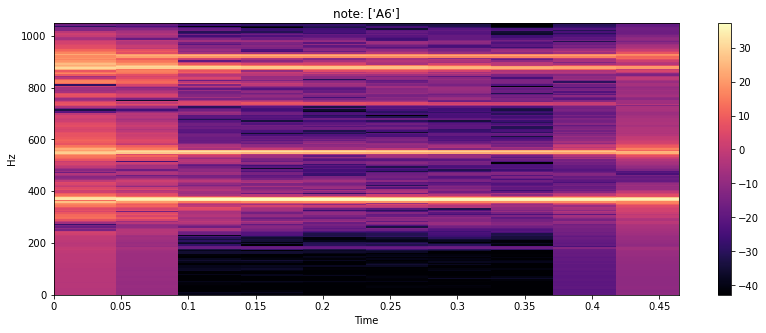

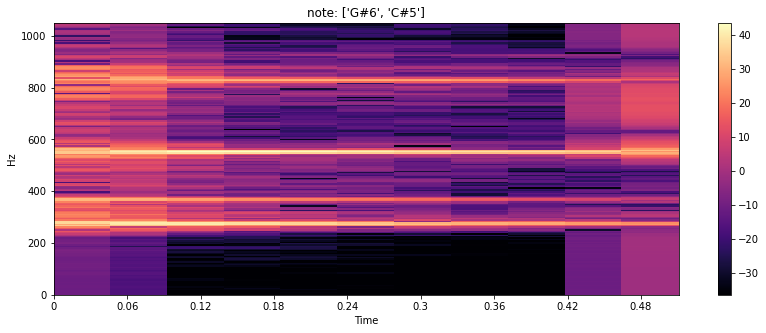

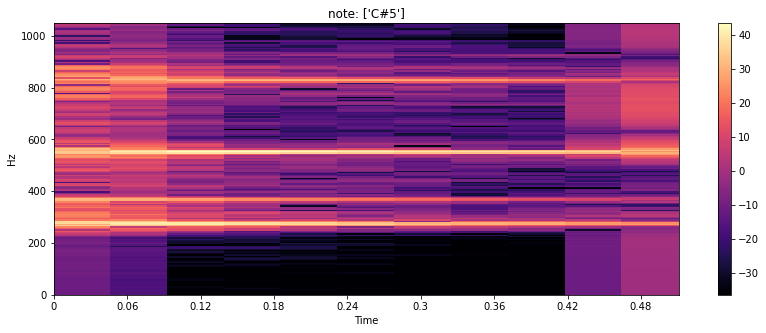

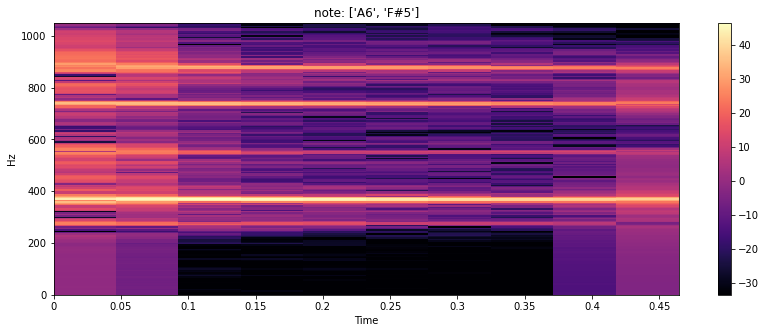

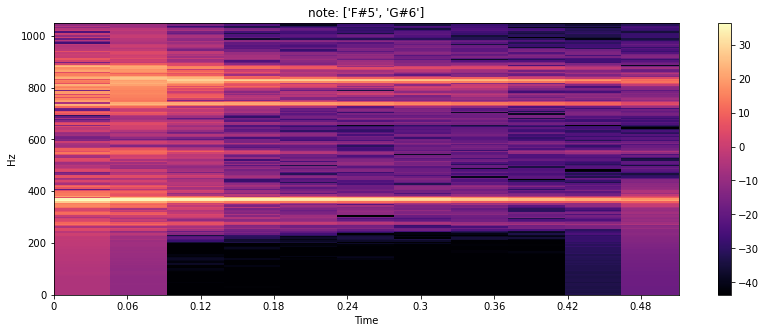

In [28]:
X, y = gen_dataset(chords, onsets_extracted, onsets_timestamps)

In [41]:
X.shape

(582, 4097)

In [37]:
np.savez("river_data.npz", {"X": X, "y": y})